# $$ \text{Experiments Keyword Extraction} $$

## Import libraries

In [1]:
from pyspark.sql import SparkSession, functions as F, types as T
from pyspark.sql.window import Window
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, IDF, NGram
from pyspark.ml import Pipeline

from sentence_transformers import SentenceTransformer

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8"); sns.set_theme(style="whitegrid", palette="Set2")

import math
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()

## Create SparkSession and Data URLs

In [2]:
spark = SparkSession.builder.appName("kw-exp").getOrCreate()
spark.conf.set("spark.sql.shuffle.partitions", "200")

In [3]:
DATA_RAW   = "/opt/data/raw"
DATA_GOLD  = "/opt/data/gold"

## Load Raw Data (.parquet)

In [4]:
df_raw = spark.read.parquet(f"{DATA_RAW}/**/*.parquet")
df_raw.show(5)

+-----------+--------------------+--------------------+----+--------------------+--------------------+--------------------+--------+--------------------+------------+
|         id|               title|            abstract|year|             authors|       keywords_gold|            doc_text|n_tokens|                 uid|doc_text_len|
+-----------+--------------------+--------------------+----+--------------------+--------------------+--------------------+--------+--------------------+------------+
|W4385245566|MizAR 60 for Miza...|As a present to M...|2023|[Ashish Vaswani, ...|[Computer science...|MizAR 60 for Miza...|     125|8020c80a09ff29eb2...|         792|
|W4320013936|Generative Advers...|                    |2023|[Raphael Labaca-C...|[Discriminator, G...|Generative Advers...|       3|61b2d27e625509c3c...|          27|
|W4315754639|Cancer statistics...|Abstract Each yea...|2023|[Rebecca L. Siege...|[Medicine, Cancer...|Cancer statistics...|     320|77a669afaf0cc9598...|        2094

In [5]:
df_raw.count()

8000

In [6]:
# Select target columns
df_doc = df_raw.select("uid", "year", "title", "abstract", "doc_text")
df_doc.show(5)

+--------------------+----+--------------------+--------------------+--------------------+
|                 uid|year|               title|            abstract|            doc_text|
+--------------------+----+--------------------+--------------------+--------------------+
|8020c80a09ff29eb2...|2023|MizAR 60 for Miza...|As a present to M...|MizAR 60 for Miza...|
|61b2d27e625509c3c...|2023|Generative Advers...|                    |Generative Advers...|
|77a669afaf0cc9598...|2023|Cancer statistics...|Abstract Each yea...|Cancer statistics...|
|c836adc65c413122d...|2023|Evaluating the Ef...|This research foc...|Evaluating the Ef...|
|f39415efdd995bda2...|2023|Suspending OpenMP...|                    |Suspending OpenMP...|
+--------------------+----+--------------------+--------------------+--------------------+
only showing top 5 rows



## Tokenization and Remove StopWords

In [7]:
tok = RegexTokenizer(inputCol="doc_text", outputCol="tokens", pattern="\\W+", toLowercase=True, minTokenLength=2)

custom_stop = ["we","our","paper","show","result","results","approach", "experiments", "also",
               "method","methods","propose","introduction","related","work", "systems",
               "section","figure","table","study","based","using","model",
               "data","analysis","problem","task","algorithm","performance"]
sw = StopWordsRemover(inputCol="tokens", outputCol="tokens_sw")
sw = sw.setStopWords(sw.getStopWords() + custom_stop)

## N-Gram

In [8]:
ng2 = NGram(n=2, inputCol="tokens_sw", outputCol="bigrams")

@F.udf("array<string>")
def merge_terms(tokens_sw, bigrams):
    if tokens_sw is None:
        tokens_sw = []
    if bigrams is None:
        bigrams = []
    terms = list(tokens_sw)

    for bg in bigrams:
        if not bg:
            continue
        w1, w2 = bg.split()
        if w1 in custom_stop or w2 in custom_stop:
            continue
        terms.append(bg)

    seen = set()
    uniq = []
    for t in terms:
        if t not in seen:
            seen.add(t)
            uniq.append(t)
    return uniq

## Create Pipeline Preprocess

In [9]:
# Pipeline preprocess
pipe = Pipeline(stages=[tok, sw, ng2])
pp = pipe.fit(df_doc)

# Preprocessed Data
df_pp = (
    pp.transform(df_doc)
    .withColumn(
        "terms", 
        merge_terms(F.col("tokens_sw"), F.col("bigrams"))
    )
)

df_pp.show(5)

+--------------------+----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                 uid|year|               title|            abstract|            doc_text|              tokens|           tokens_sw|             bigrams|               terms|
+--------------------+----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|8020c80a09ff29eb2...|2023|MizAR 60 for Miza...|As a present to M...|MizAR 60 for Miza...|[mizar, 60, for, ...|[mizar, 60, mizar...|[mizar 60, 60 miz...|[mizar, 60, 50, p...|
|61b2d27e625509c3c...|2023|Generative Advers...|                    |Generative Advers...|[generative, adve...|[generative, adve...|[generative adver...|[generative, adve...|
|77a669afaf0cc9598...|2023|Cancer statistics...|Abstract Each yea...|Cancer statistics...|[cancer, statisti...|[cancer, stati

# $$ \text{Term Frequency - Inverse Document Frequency (TF-IDF)} $$ 

In [10]:
# Stage TF and IDF
cv = CountVectorizer(inputCol="terms", outputCol="tf", minDF=3)
idf = IDF(inputCol="tf", outputCol="tfidf")

# Fit, Transform
cv_model = cv.fit(df_pp)
df_tf = cv_model.transform(df_pp)

idf_model = idf.fit(df_tf)
df_tfidf = idf_model.transform(df_tf)

## Keyword Extraction (TF-IDF)

In [11]:
# Max keyword
K = 10

# Vocab pretrained from CountVectorizer
vocab = cv_model.vocabulary

In [12]:
# UDF: List top-K term (by name) from vector TF-IDF
@F.udf("array<string>")
def topk_terms(v):
    if v is None: return []
    idx = list(v.indices)
    val = list(v.values)
    pairs = sorted(zip(idx, val), key=lambda x: x[1], reverse=True)[:K]
    return [vocab[i] for i,_ in pairs]

# UDF: List top-K score (by TF-IDF Score) corresponding with terms
@F.udf("array<double>")
def topk_scores(v):
    if v is None: return []
    idx = list(v.indices)
    val = list(v.values)
    pairs = sorted(zip(idx, val), key=lambda x: x[1], reverse=True)[:K]
    return [float(s) for _,s in pairs]

In [13]:
# Extract Keyword per Doc
df_kw_tfidf = (
    df_tfidf
    .select(
        "uid","year",
        topk_terms("tfidf").alias("keywords"),
        topk_scores("tfidf").alias("scores")
    )
    # Add "method" column to mark extraction method (here is tfidf),
    # later can add TextRank, KeyBERT,... common schema
    .withColumn("method", F.lit("tfidf"))
)


df_kw_tfidf.show(5)

+--------------------+----+--------------------+--------------------+------+
|                 uid|year|            keywords|              scores|method|
+--------------------+----+--------------------+--------------------+------+
|8020c80a09ff29eb2...|2023|[50th anniversary...|[7.60102745173023...| tfidf|
|61b2d27e625509c3c...|2023|[adversarial nets...|[7.60102745173023...| tfidf|
|77a669afaf0cc9598...|2023|[foreshadows, con...|[7.60102745173023...| tfidf|
|c836adc65c413122d...|2023|[geospatial, eval...|[7.60102745173023...| tfidf|
|f39415efdd995bda2...|2023|[openmp, asynchro...|[7.60102745173023...| tfidf|
+--------------------+----+--------------------+--------------------+------+
only showing top 5 rows



In [14]:
# Change from "each line = 1 document with list keyword" to "each line = 1 keyword"
df_kw_tfidf_long = (
    df_kw_tfidf
    .select(
        "uid","year","method",
        # posexplode_outer(keywords) splits the keywords array into multiple lines:
        #   - rank: index position in the array (0,1,2,...) = keyword rank
        #   - keyword: string value
        F.posexplode_outer("keywords").alias("rank","keyword"),
        F.col("scores").getItem(F.col("rank")).alias("score")
    )
    .withColumn("rank", F.col("rank").cast("long"))
)

df_kw_tfidf_long.show(5)

/usr/local/spark/python/pyspark/sql/column.py:460: FutureWarning: A column as 'key' in getItem is deprecated as of Spark 3.0, and will not be supported in the future release. Use `column[key]` or `column.key` syntax instead.
  warnings.warn(


+--------------------+----+------+----+----------------+------------------+
|                 uid|year|method|rank|         keyword|             score|
+--------------------+----+------+----+----------------+------------------+
|8020c80a09ff29eb2...|2023| tfidf|   0|50th anniversary| 7.601027451730233|
|8020c80a09ff29eb2...|2023| tfidf|   1|            50th| 7.377883900416023|
|8020c80a09ff29eb2...|2023| tfidf|   2|             atp| 7.195562343622069|
|8020c80a09ff29eb2...|2023| tfidf|   3|        theorems|6.9078802711702885|
|8020c80a09ff29eb2...|2023| tfidf|   4|          proves|6.9078802711702885|
+--------------------+----+------+----+----------------+------------------+
only showing top 5 rows



# $$ \text{KeyBERT-style (Embedding-based)} $$

## Load model

In [15]:
# !pip install -q keybert sentence-transformers

In [16]:
model = SentenceTransformer('all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## Keyword Extraction (KeyBERT-style)

In [17]:
def keybert_like(doc, terms, top_k=K):
    if not doc or not terms:
        return [], []

    seen = set()
    cand = []
    for t in terms:
        if t not in seen:
            seen.add(t)
            cand.append(t)
    if not cand:
        return [], []

    doc_emb = model.encode([doc], normalize_embeddings=True)[0]
    term_emb = model.encode(cand, normalize_embeddings=True)
    
    # cosine = dot, because normalized
    scores = term_emb @ doc_emb

    idx = scores.argsort()[::-1][:top_k]
    kws = [cand[i] for i in idx]
    scr = [float(scores[i]) for i in idx]
    return kws, scr

In [18]:
# Convert Dataframe, to avoid crash
pdf = (
    df_pp
    .select("uid", "year", "doc_text", "terms")
    .where(F.size("terms") > 0)
    .toPandas()
)

results = pdf.progress_apply(
    lambda row: keybert_like(row["doc_text"], row["terms"]),
    axis=1
)

pdf["keywords"] = results.apply(lambda x: x[0])
pdf["scores"]   = results.apply(lambda x: x[1])

  0%|          | 0/7999 [00:00<?, ?it/s]

In [19]:
# Change from "each line = 1 document with list keyword" to "each line = 1 keyword"

rows = []
for _, row in pdf.iterrows():
    uid = row["uid"]
    year = row["year"]
    kws = row["keywords"]
    scr = row["scores"]
    for r, (k, s) in enumerate(zip(kws, scr)):
        rows.append({
            "uid": uid,
            "year": year,
            "method": "keybert_like",
            "rank": r,
            "keyword": k,
            "score": float(s),
        })

pdf_long = pd.DataFrame(rows)
df_kw_keybert_long = spark.createDataFrame(pdf_long).withColumn("rank", F.col("rank").cast("long"))
df_kw_keybert_long.show(5)

+--------------------+----+------------+----+-------------------+------------------+
|                 uid|year|      method|rank|            keyword|             score|
+--------------------+----+------------+----+-------------------+------------------+
|8020c80a09ff29eb2...|2023|keybert_like|   0|       mizar proofs|0.5794463753700256|
|8020c80a09ff29eb2...|2023|keybert_like|   1|  automated provers|0.5724890232086182|
|8020c80a09ff29eb2...|2023|keybert_like|   2| theorems automated|0.5681775808334351|
|8020c80a09ff29eb2...|2023|keybert_like|   3|    proofs training|0.5429744720458984|
|8020c80a09ff29eb2...|2023|keybert_like|   4|automatically prove|0.4806763231754303|
+--------------------+----+------------+----+-------------------+------------------+
only showing top 5 rows



# $$ \text{TextRank (Graph-based)} $$

## PageRank

In [20]:
# pip install networkx

In [21]:
import networkx as nx

In [22]:
@F.udf("array<string>")
def textrank_terms_udf(terms: list):
    if terms is None or len(terms) == 0:
        return []
    
    # Build a co-occurrence graph
    window = 4
    G = nx.Graph()
    G.add_nodes_from(terms)
    
    # Add edges between terms in the same window
    n = len(terms)
    for i in range(n):
        for j in range(i+1, min(i+window, n)):
            if terms[i] == terms[j]:
                continue
            if G.has_edge(terms[i], terms[j]):
                G[terms[i]][terms[j]]["weight"] += 1.0
            else:
                G.add_edge(terms[i], terms[j], weight=1.0)
    
    if G.number_of_edges() == 0:
        # fallback: return simple term
        return terms[:K]
    
    # Run PageRank
    scores = nx.pagerank(G, weight="weight")
    
    # Sort by score descending, get top-K
    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:K]
    return [t for t, s in ranked]

@F.udf("array<double>")
def textrank_scores_udf(terms: list):
    if terms is None or len(terms) == 0:
        return []
    
    window = 4
    G = nx.Graph()
    G.add_nodes_from(terms)
    n = len(terms)
    for i in range(n):
        for j in range(i+1, min(i+window, n)):
            if terms[i] == terms[j]:
                continue
            if G.has_edge(terms[i], terms[j]):
                G[terms[i]][terms[j]]["weight"] += 1.0
            else:
                G.add_edge(terms[i], terms[j], weight=1.0)
    
    if G.number_of_edges() == 0:
        return [1.0] * min(K, len(terms))
    
    scores = nx.pagerank(G, weight="weight")
    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:K]
    return [float(s) for t, s in ranked]

## Keyword Extraction (TextRank)

In [23]:
df_kw_textrank = (
    df_pp
    .select(
        "uid",
        "year",
        textrank_terms_udf(F.col("terms")).alias("keywords"),
        textrank_scores_udf(F.col("terms")).alias("scores")
    )
    .withColumn("method", F.lit("textrank"))
)

df_kw_textrank.show(5)

+--------------------+----+--------------------+--------------------+--------+
|                 uid|year|            keywords|              scores|  method|
+--------------------+----+--------------------+--------------------+--------+
|8020c80a09ff29eb2...|2023|[present, selecti...|[0.00985981724709...|textrank|
|61b2d27e625509c3c...|2023|[adversarial, net...|[0.21988291621804...|textrank|
|77a669afaf0cc9598...|2023|[abstract, happen...|[0.00344062824001...|textrank|
|c836adc65c413122d...|2023|[language, variou...|[0.00777499419155...|textrank|
|f39415efdd995bda2...|2023|[asynchronous, as...|[0.07678504869965...|textrank|
+--------------------+----+--------------------+--------------------+--------+
only showing top 5 rows



In [24]:
df_kw_textrank_long = df_kw_textrank.select(
    "uid", "year", "method",
    F.posexplode_outer(F.col("keywords")).alias("rank", "keyword"),
    F.col("scores").getItem(F.col("rank")).alias("score")
).withColumn("rank", F.col("rank").cast("long"))

df_kw_textrank_long.show(5)

/usr/local/spark/python/pyspark/sql/column.py:460: FutureWarning: A column as 'key' in getItem is deprecated as of Spark 3.0, and will not be supported in the future release. Use `column[key]` or `column.key` syntax instead.
  warnings.warn(


+--------------------+----+--------+----+-----------------+--------------------+
|                 uid|year|  method|rank|          keyword|               score|
+--------------------+----+--------+----+-----------------+--------------------+
|8020c80a09ff29eb2...|2023|textrank|   0|          present| 0.00985981724709048|
|8020c80a09ff29eb2...|2023|textrank|   1|  selection mizar| 0.00985981724709048|
|8020c80a09ff29eb2...|2023|textrank|   2|present selection|0.009582691551050402|
|8020c80a09ff29eb2...|2023|textrank|   3|             50th|  0.0095826915510504|
|8020c80a09ff29eb2...|2023|textrank|   4|      anniversary|0.009374881896203854|
+--------------------+----+--------+----+-----------------+--------------------+
only showing top 5 rows



## Store

In [25]:
from functools import reduce

dfs = [df_kw_tfidf_long, df_kw_keybert_long, df_kw_textrank_long]

for i in range(len(dfs)):
    dfs[i] = (dfs[i]
              .select("uid","year","method","rank","keyword","score")
              .withColumn("rank", F.col("rank").cast("long"))
              .withColumn("score", F.col("score").cast("double")))

df_kw_all = reduce(lambda a,b: a.unionByName(b), dfs)

df_kw_all.printSchema()
df_kw_all.show(5)

root
 |-- uid: string (nullable = true)
 |-- year: long (nullable = true)
 |-- method: string (nullable = true)
 |-- rank: long (nullable = true)
 |-- keyword: string (nullable = true)
 |-- score: double (nullable = true)

+--------------------+----+------+----+----------------+------------------+
|                 uid|year|method|rank|         keyword|             score|
+--------------------+----+------+----+----------------+------------------+
|8020c80a09ff29eb2...|2023| tfidf|   0|50th anniversary| 7.601027451730233|
|8020c80a09ff29eb2...|2023| tfidf|   1|            50th| 7.377883900416023|
|8020c80a09ff29eb2...|2023| tfidf|   2|             atp| 7.195562343622069|
|8020c80a09ff29eb2...|2023| tfidf|   3|        theorems|6.9078802711702885|
|8020c80a09ff29eb2...|2023| tfidf|   4|          proves|6.9078802711702885|
+--------------------+----+------+----+----------------+------------------+
only showing top 5 rows



In [26]:
df_kw_all.write.mode("overwrite") \
    .partitionBy("method","year") \
    .parquet(f"{DATA_GOLD}/keywords")

# $$ \text{Evaluate} $$

## Predicted Data

In [27]:
DATA_GOLD = "/opt/data/gold"
DATA_BRONZE = "/opt/data/raw"

In [28]:
df_pred_long = spark.read.parquet(f"{DATA_GOLD}/keywords")

df_pred_long.printSchema()
df_pred_long.show(5, truncate=True)

root
 |-- uid: string (nullable = true)
 |-- rank: long (nullable = true)
 |-- keyword: string (nullable = true)
 |-- score: double (nullable = true)
 |-- method: string (nullable = true)
 |-- year: integer (nullable = true)

+--------------------+----+-----------------+-------------------+------------+----+
|                 uid|rank|          keyword|              score|      method|year|
+--------------------+----+-----------------+-------------------+------------+----+
|3a28648a83bb3e11e...|   6|      stroke 2019| 0.4993228018283844|keybert_like|2019|
|3a28648a83bb3e11e...|   7|   acute ischemic| 0.4864165186882019|keybert_like|2019|
|3a28648a83bb3e11e...|   8|  stroke intended| 0.4840535521507263|keybert_like|2019|
|3a28648a83bb3e11e...|   9|arterial ischemic|0.47926074266433716|keybert_like|2019|
|e5327fcf75fd4a601...|   0|   dual attention| 0.5459351539611816|keybert_like|2019|
+--------------------+----+-----------------+-------------------+------------+----+
only showing top 5

In [29]:
df_openalex = spark.read.parquet(f"{DATA_BRONZE}/**/*.parquet")

df_openalex.select("uid", "title", "doc_text", "keywords_gold").show(5)

+--------------------+--------------------+--------------------+--------------------+
|                 uid|               title|            doc_text|       keywords_gold|
+--------------------+--------------------+--------------------+--------------------+
|8020c80a09ff29eb2...|MizAR 60 for Miza...|MizAR 60 for Miza...|[Computer science...|
|61b2d27e625509c3c...|Generative Advers...|Generative Advers...|[Discriminator, G...|
|77a669afaf0cc9598...|Cancer statistics...|Cancer statistics...|[Medicine, Cancer...|
|c836adc65c413122d...|Evaluating the Ef...|Evaluating the Ef...|[Computer science...|
|f39415efdd995bda2...|Suspending OpenMP...|Suspending OpenMP...|[Asynchronous com...|
+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



## Collect keyword list (sorted by rank)

In [30]:
df_pred = (
    df_pred_long
    .groupBy("uid", "method")
    .agg(
        F.sort_array(
            F.collect_list(F.struct("rank", "keyword")),
            asc=True
        ).alias("kw_structs")
    )
    .select(
        "uid", "method",
        F.expr("transform(kw_structs, x -> x.keyword)").alias("pred_keywords")
    )
)

df_pred.show(5)

+--------------------+--------+--------------------+
|                 uid|  method|       pred_keywords|
+--------------------+--------+--------------------+
|001f4fe99c63d900a...|textrank|[opportunities ne...|
|00359337c15380c31...|textrank|[support unlimite...|
|00572c6774c31dfd2...|textrank|[information supp...|
|005a8bb8206383af0...|textrank|[defence, ferropt...|
|005a8bb8206383af0...|   tfidf|[defence, vulnera...|
+--------------------+--------+--------------------+
only showing top 5 rows



## Normalize

In [31]:
@F.udf("array<string>")
def normalize_terms(arr):
    if arr is None:
        return []
    out = []
    for t in arr:
        if not t:
            continue
        s = t.lower().strip()
        s = "".join(ch for ch in s if ch.isalnum() or ch.isspace())
        s = " ".join(s.split())
        if s:
            out.append(s)
    seen = set()
    uniq = []
    for x in out:
        if x not in seen:
            seen.add(x)
            uniq.append(x)
    return uniq

df_pred_n = df_pred.withColumn("pred_norm", normalize_terms("pred_keywords"))
df_gold_n = df_openalex.withColumn("gold_norm", normalize_terms("keywords_gold"))

In [32]:
# Join Gold - Pred
df_eval = (
    df_pred_n.alias("p")
    .join(
        df_gold_n.select("uid", "gold_norm").alias("g"),
        on="uid",
        how="inner"
    )
    .filter(F.size("gold_norm") > 0)
    .select("uid", "method", "pred_norm", "gold_norm")
)

df_eval.show(5)

+--------------------+--------+--------------------+--------------------+
|                 uid|  method|           pred_norm|           gold_norm|
+--------------------+--------+--------------------+--------------------+
|00359337c15380c31...|textrank|[support unlimite...|[biology, identif...|
|00572c6774c31dfd2...|textrank|[information supp...|[computer science...|
|005a8bb8206383af0...|textrank|[defence, ferropt...|[gpx4, dihydrooro...|
|005a8bb8206383af0...|   tfidf|[defence, vulnera...|[gpx4, dihydrooro...|
|00601383c1d031a72...|textrank|[guideline, thera...|[medicine, guidel...|
+--------------------+--------+--------------------+--------------------+
only showing top 5 rows



## Metrics

### P@K, R@K, F1@K

In [33]:
Ks = [5, 10, 20]

metric_schema = T.StructType([
    T.StructField("K", T.IntegerType()),
    T.StructField("precision", T.DoubleType()),
    T.StructField("recall", T.DoubleType()),
    T.StructField("f1", T.DoubleType()),
])

@F.udf(T.ArrayType(metric_schema))
def prf_at_k(pred, gold):
    if pred is None: pred = []
    if gold is None or len(gold) == 0:
        return []
    gset = set(gold)
    out = []
    for K in Ks:
        topk = pred[:K]
        if not topk:
            prec = 0.0
            inter = 0
        else:
            inter = len([t for t in topk if t in gset])
            prec = inter / len(topk)
        rec = inter / len(gold)
        f1 = 0.0 if (prec + rec == 0) else 2 * prec * rec / (prec + rec)
        out.append({
            "K": int(K),
            "precision": float(prec),
            "recall": float(rec),
            "f1": float(f1),
        })
    return out

In [34]:
df_prf = df_eval.select(
    "uid", "method",
    prf_at_k("pred_norm", "gold_norm").alias("metrics")
)

df_prf_long = df_prf.select(
    "uid", "method",
    F.explode("metrics").alias("m")
).select(
    "uid", "method",
    F.col("m.K").alias("K"),
    "m.precision", "m.recall", "m.f1"
)

df_prf_summary = (
    df_prf_long
    .groupBy("method", "K")
    .agg(
        F.avg("precision").alias("P"),
        F.avg("recall").alias("R"),
        F.avg("f1").alias("F1")
    )
    .orderBy("method", "K")
)

In [35]:
df_prf_summary.show(5)

+------------+---+--------------------+-------------------+--------------------+
|      method|  K|                   P|                  R|                  F1|
+------------+---+--------------------+-------------------+--------------------+
|keybert_like|  5| 0.09708967851099888|0.04591092503007248| 0.05911821165448391|
|keybert_like| 10| 0.08415155910079751|0.07182000493008009| 0.07333123251708665|
|keybert_like| 20| 0.08415155910079751|0.07182000493008009| 0.07333123251708665|
|    textrank|  5| 0.06791862284820066| 0.0324533639254073|0.041431424499701906|
|    textrank| 10|0.061085431507966984|0.05019739992355421| 0.05208586777005737|
+------------+---+--------------------+-------------------+--------------------+
only showing top 5 rows



### MRR@K

In [36]:
@F.udf("double")
def mrr_at_k(pred, gold, K):
    if not gold:
        return 0.0
    gset = set(gold)
    topk = pred[:K] if pred else []
    for i, w in enumerate(topk, start=1):
        if w in gset:
            return 1.0 / i
    return 0.0

In [37]:
df_mrr = (
    df_eval
    .withColumn("MRR5",  mrr_at_k("pred_norm","gold_norm", F.lit(5)))
    .withColumn("MRR10", mrr_at_k("pred_norm","gold_norm", F.lit(10)))
    .withColumn("MRR20", mrr_at_k("pred_norm","gold_norm", F.lit(20)))
)

df_mrr_summary = (
    df_mrr.groupBy("method")
    .agg(F.avg("MRR5"), F.avg("MRR10"), F.avg("MRR20"))
    .orderBy("method")
)

In [38]:
df_mrr_summary.show(5)

+------------+-------------------+-------------------+-------------------+
|      method|          avg(MRR5)|         avg(MRR10)|         avg(MRR20)|
+------------+-------------------+-------------------+-------------------+
|keybert_like| 0.2090186125211505|0.22874828780920128|0.22874828780920128|
|    textrank| 0.1543184029099522|0.17041865809471438|0.17041865809471438|
|       tfidf|0.13677198325085646| 0.1525294409097225| 0.1525294409097225|
+------------+-------------------+-------------------+-------------------+



### MAP@K nDCG@K

In [39]:
# AP@K -> MAP@K

@F.udf("double")
def ap_at_k(pred, gold, K):
    if pred is None: pred = []
    if gold is None or len(gold) == 0:
        return 0.0
    gset = set(gold)
    hits = 0
    sum_prec = 0.0
    for i, t in enumerate(pred[:K], start=1):
        if t in gset:
            hits += 1
            sum_prec += hits / i
    if hits == 0:
        return 0.0
    return float(sum_prec / hits)

In [40]:
Kmap = 20

df_ap = df_eval.select(
    "uid", "method",
    ap_at_k("pred_norm", "gold_norm", F.lit(Kmap)).alias("AP")
)

df_map = (
    df_ap.groupBy("method")
    .agg(F.avg("AP").alias("MAP"))
    .orderBy("method")
)

In [41]:
df_map.show(5)

+------------+-------------------+
|      method|                MAP|
+------------+-------------------+
|keybert_like| 0.2155493748824964|
|    textrank|0.16248363722542117|
|       tfidf|0.14687353097564354|
+------------+-------------------+



In [42]:
# nDCG@K

@F.udf("double")
def ndcg_at_k(pred, gold, K):
    if pred is None: pred = []
    if gold is None or len(gold) == 0:
        return 0.0
    gset = set(gold)
    dcg = 0.0
    for i, t in enumerate(pred[:K], start=1):
        rel = 1.0 if t in gset else 0.0
        if rel > 0:
            dcg += rel / math.log2(i + 1)
    G = min(len(gold), K)
    idcg = sum(1.0 / math.log2(i + 1) for i in range(1, G + 1))
    if idcg == 0:
        return 0.0
    return float(dcg / idcg)

In [43]:
Kdcg = 20

df_ndcg = df_eval.select(
    "uid", "method",
    ndcg_at_k("pred_norm", "gold_norm", F.lit(Kdcg)).alias("nDCG")
)

df_ndcg_summary = (
    df_ndcg.groupBy("method")
    .agg(F.avg("nDCG").alias("nDCG"))
    .orderBy("method")
)

In [44]:
df_ndcg_summary.show(5)

+------------+-------------------+
|      method|               nDCG|
+------------+-------------------+
|keybert_like|0.07992797176535532|
|    textrank|0.05715474613208603|
|       tfidf|0.05567893517260516|
+------------+-------------------+



## Visualization

### F1@K

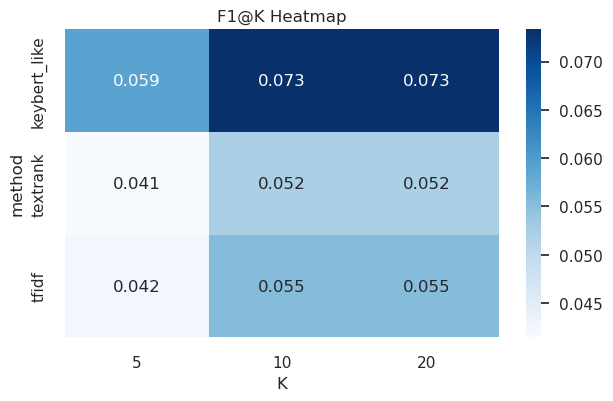

In [45]:
pdf = df_prf_summary.toPandas()

heat = pdf.pivot(index="method", columns="K", values="F1")

plt.figure(figsize=(7,4))
sns.heatmap(heat, annot=True, cmap="Blues", fmt=".3f")
plt.title("F1@K Heatmap")
plt.show()

### MAP and nDCG

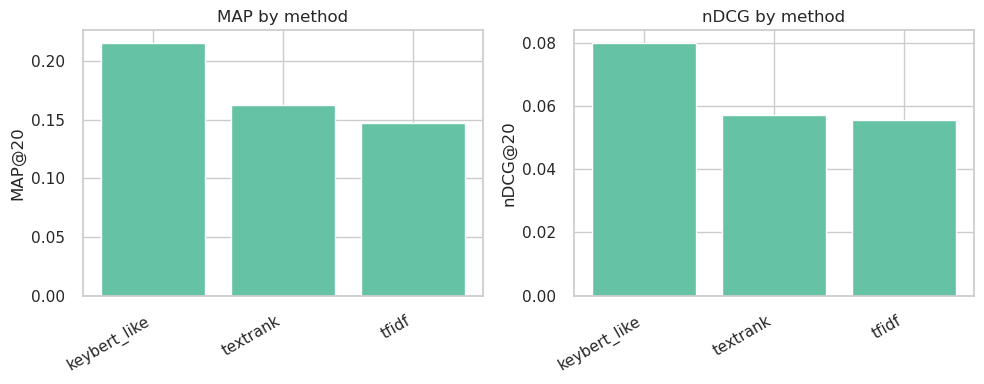

In [46]:
pdf_map = df_map.toPandas()
pdf_ndcg = df_ndcg_summary.toPandas()

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.bar(pdf_map["method"], pdf_map["MAP"])
plt.ylabel(f"MAP@{Kmap}")
plt.xticks(rotation=30, ha="right")
plt.title("MAP by method")

plt.subplot(1,2,2)
plt.bar(pdf_ndcg["method"], pdf_ndcg["nDCG"])
plt.ylabel(f"nDCG@{Kdcg}")
plt.xticks(rotation=30, ha="right")
plt.title("nDCG by method")

plt.tight_layout()
plt.show()

### Distribution of correct hits

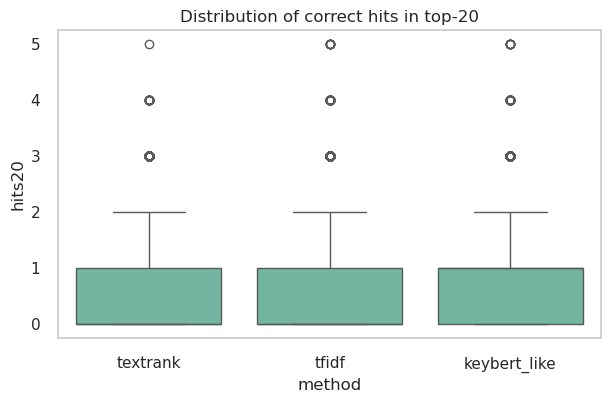

In [47]:
@F.udf("int")
def hit_count(pred, gold):
    if not gold:
        return 0
    g = set(gold)
    return int(len([w for w in pred[:20] if w in g]))

df_hits = df_eval.withColumn("hits20", hit_count("pred_norm","gold_norm"))

pdf_hits = df_hits.select("method","hits20").toPandas()

plt.figure(figsize=(7,4))
sns.boxplot(data=pdf_hits, x="method", y="hits20")
plt.title("Distribution of correct hits in top-20")
plt.grid(axis="y")
plt.show()

### WordCloud

In [48]:
# !pip -q install wordcloud

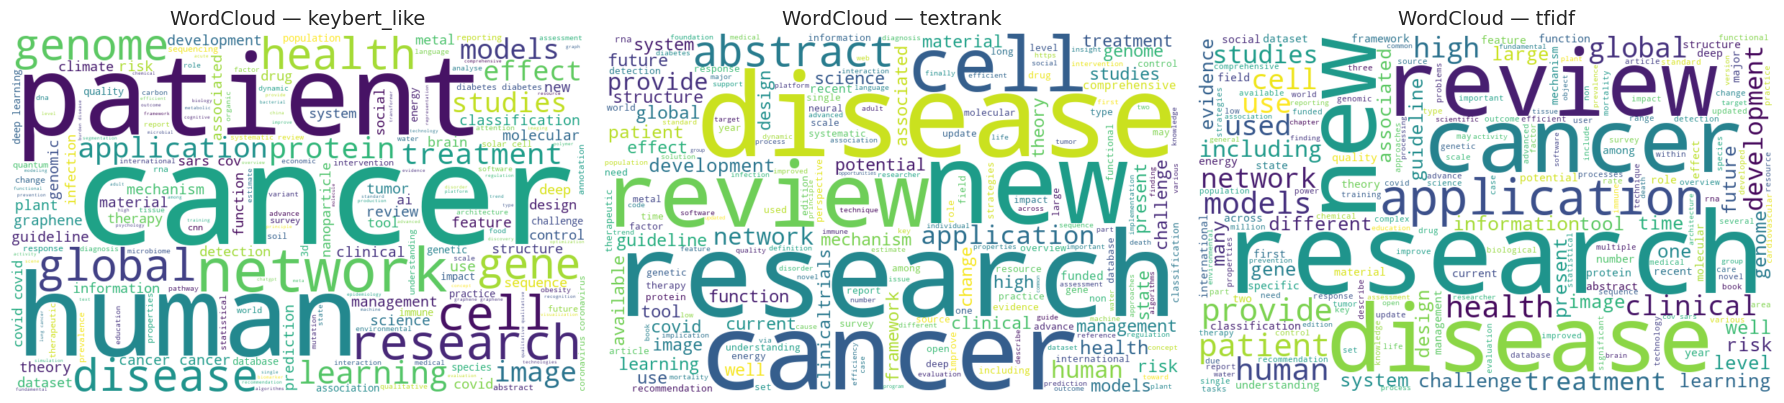

In [49]:
from wordcloud import WordCloud

pdf_pred = df_pred_long.toPandas()
pdf_pred["keyword"] = pdf_pred["keyword"].fillna("").astype(str)

methods = pdf_pred["method"].unique()
methods = sorted(methods)[:3]

plt.figure(figsize=(18, 5))

for i, m in enumerate(methods, start=1):
    sub = pdf_pred[pdf_pred["method"] == m]
    kws = [k for k in sub["keyword"] if isinstance(k, str) and k.strip() != ""]
    text = " ".join(kws)

    wc = WordCloud(width=800, height=500, background_color="white").generate(text)
    
    plt.subplot(1, 3, i)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud — {m}", fontsize=14)

plt.tight_layout()
plt.show()

### Keyword Overlap Matrix (Jaccard)

In [50]:
df_method_kw = (
    df_pred_long.groupBy("method")
    .agg(F.collect_set("keyword").alias("kw_set"))
)
pdf_method_kw = df_method_kw.toPandas()

In [51]:
methods = pdf_method_kw["method"].tolist()
kw_sets = {row["method"]: set(row["kw_set"]) for _, row in pdf_method_kw.iterrows()}

mat = np.zeros((len(methods), len(methods)))

for i,m1 in enumerate(methods):
    for j,m2 in enumerate(methods):
        inter = len(kw_sets[m1].intersection(kw_sets[m2]))
        union = len(kw_sets[m1].union(kw_sets[m2]))
        mat[i,j] = inter/union if union>0 else 0

df_overlap = pd.DataFrame(mat, index=methods, columns=methods)

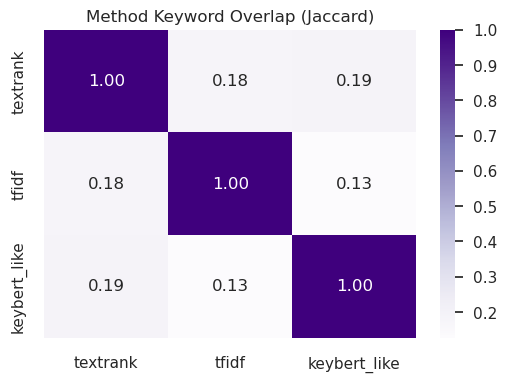

In [52]:
plt.figure(figsize=(6,4))
sns.heatmap(df_overlap, annot=True, cmap="Purples", fmt=".2f")
plt.title("Method Keyword Overlap (Jaccard)")
plt.show()

### Semantic Similarity Distribution

In [53]:
df_sem = (
    df_pred_n.alias("p")
    .join(
        df_gold_n.select("uid", "doc_text", "gold_norm").alias("g"),
        on="uid",
        how="inner"
    )
    .filter(F.size("gold_norm") > 0)
    .select("uid", "method", "doc_text", "pred_norm", "gold_norm")
)

df_sem.show(5)

+--------------------+--------+--------------------+--------------------+--------------------+
|                 uid|  method|            doc_text|           pred_norm|           gold_norm|
+--------------------+--------+--------------------+--------------------+--------------------+
|00359337c15380c31...|textrank|The UNITE databas...|[support unlimite...|[biology, identif...|
|00572c6774c31dfd2...|textrank|GROMACS 4.5: a hi...|[information supp...|[computer science...|
|005a8bb8206383af0...|textrank|DHODH-mediated fe...|[defence, ferropt...|[gpx4, dihydrooro...|
|005a8bb8206383af0...|   tfidf|DHODH-mediated fe...|[defence, vulnera...|[gpx4, dihydrooro...|
|00601383c1d031a72...|textrank|CDC Clinical Prac...|[guideline, thera...|[medicine, guidel...|
+--------------------+--------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [54]:
pdf_eval = df_sem.sample(0.1).limit(2000).toPandas()

In [55]:
embedder = SentenceTransformer("all-MiniLM-L6-v2")

def sem_sim(pred, doc):
    if not pred or not doc or len(pred)==0:
        return 0.0
    kw = pred[0]
    emb = embedder.encode([kw, doc], normalize_embeddings=True)
    return float(np.dot(emb[0], emb[1]))

In [56]:
pdf_eval["sem_sim"] = pdf_eval.progress_apply(
    lambda r: sem_sim(r["pred_norm"], r["doc_text"]), axis=1
)

  0%|          | 0/2000 [00:00<?, ?it/s]

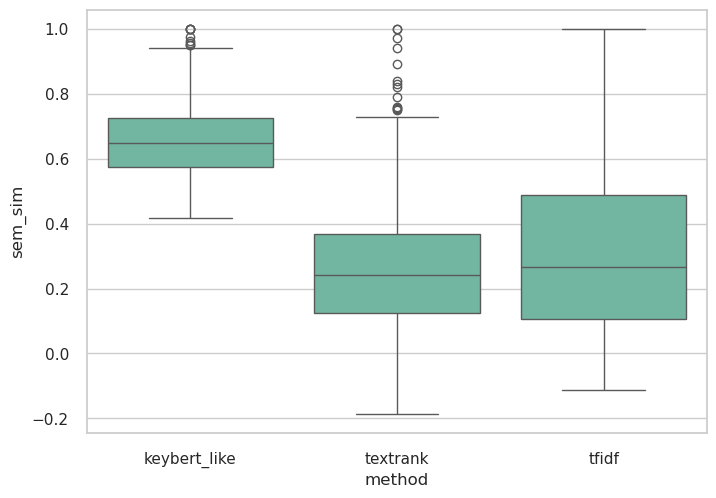

In [57]:
sns.boxplot(data=pdf_eval, x="method", y="sem_sim")
plt.show()

## Summary

1. **Jaccard Overlap**

* The Jaccard overlap between methods is very low, indicating that the three approaches generate highly distinct keyword sets.
* KeyBERT-like produces the most distinct set of keywords, consistent with its semantic-embedding nature.

2. **Semantic Similarity between keywords and document content**

* KeyBERT-like performs best, producing keywords that are semantically close to the document content.
* TextRank performs the worst, with high variance and unstable quality.

3. **Precision / Recall / F1**

* KeyBERT-like outperforms the other methods across most K levels.
* TextRank and TF-IDF show significantly lower performance, especially at F1@5 and F1@10.

4. **MRR (Mean Reciprocal Rank)**

* KeyBERT-like achieves the highest MRR, meaning correct keywords tend to appear at higher ranks.

**Conclusion:** KeyBERT-like is the most effective method on the OpenAlex-derived dataset. TextRank is less stable, less semantic, and weaker in ranking quality.

---